In [1]:
import random

import numpy as np
import json
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import geopy.distance as distance
import matplotlib.pyplot as plt
import matplotlib.markers as markers
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from random import choice
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
regions_path = "data/regions/UKR_adm1.shp"
cities_path = "data/preprocessed/cities.csv"
destinations_path = "data/preprocessed/destinations.csv"

### Plot Ukraine map with regions

In [3]:
df_regions = gpd.read_file(regions_path)
df_regions.head()


,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,240,UKR,Ukraine,1,Cherkasy,UA.CK,0,None,Oblast',Region,None,Cherkas'ka Oblast'|Cherkasskaya Oblast'|Cherkassy,"POLYGON ((32.15047 50.19769, 32.15050 50.19181..."
1,240,UKR,Ukraine,2,Chernihiv,UA.CH,0,None,Oblast',Region,None,Chernigov|Tschernigow,"POLYGON ((33.19667 52.37500, 33.20612 52.36700..."
2,240,UKR,Ukraine,3,Chernivtsi,UA.CV,0,None,Oblast',Region,None,Chernivets'ka Oblast'|Chernovitskaya Oblast'|C...,"POLYGON ((25.62595 48.67673, 25.64460 48.67159..."
3,240,UKR,Ukraine,4,Crimea,UA.KR,0,None,Autonomous Republic,Autonomous Republic,None,CrimÃ©e|CrimÃ©ia|Krim|Krymskaya Respublika|Res...,"MULTIPOLYGON (((33.79458 44.39153, 33.79291 44..."
4,240,UKR,Ukraine,5,Dnipro,UA.DP,0,None,Oblast',Region,None,Dnipropetrovsk|Dniepropietrovsk|Dnjepropetrowsk,"POLYGON ((34.92995 49.15574, 34.92076 49.14992..."


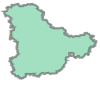

In [4]:
# there is a separate polygon shape fot Kiev city, excluded from its region
# merge them into one region and remove the city
merged_kyiv = unary_union(df_regions[df_regions['NAME_1'].isin(['Kyiv', 'Kyiv City'])]['geometry'])
df_regions = df_regions.drop(df_regions[df_regions['NAME_1'] == 'Kyiv City'].index)
df_regions.loc[df_regions['NAME_1'] == 'Kyiv', 'geometry'] = merged_kyiv

merged_kyiv

In [5]:
# set of already existing warehouses
warehouses = {'Lviv', 'Kyiv', 'Kherson'}
# cities for new warehouses
possible_warehouses = set(df_regions['NAME_1'].to_numpy()).difference(warehouses).difference({'Crimea', 'Sevastopol'})

In [6]:
df_cities = pd.read_csv(cities_path)

points = [Point(d['longitude'], d['latitude']) for d in map(json.loads, df_cities['location'].to_numpy())]

df_cities = GeoDataFrame(df_cities, geometry=points, crs=df_regions.crs)
df_cities.head()

,name,location,population,latitude,longitude,region,geometry
0,Urzuf,"{""__type"":""GeoPoint"",""latitude"":46.91562,""long...",2904,46.91562,37.09961,Donetska,POINT (37.09961 46.91562)
1,Zuhres,"{""__type"":""GeoPoint"",""latitude"":48.0114,""longi...",19121,48.0114,38.26444,Donetska,POINT (38.26444 48.01140)
2,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",22608,49.80597,24.89436,Lvivska,POINT (24.89436 49.80597)
3,Zhydachiv,"{""__type"":""GeoPoint"",""latitude"":49.38468,""long...",0,49.38468,24.14254,Lvivska,POINT (24.14254 49.38468)
4,Kovyl’noye,"{""__type"":""GeoPoint"",""latitude"":45.69028,""long...",783,45.69028,33.52775,Crimea,POINT (33.52775 45.69028)


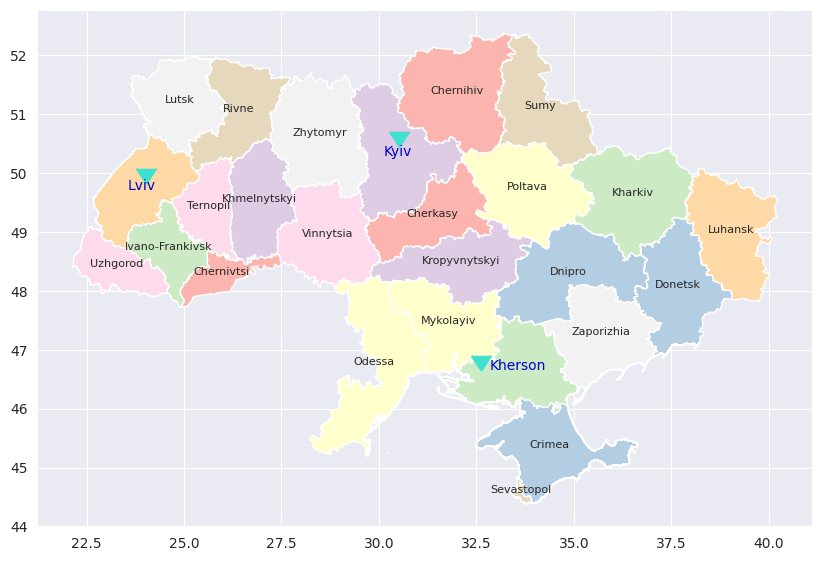

In [7]:
def plot_map(df, ax: plt.axes = None, new_warehouses: frozenset[str] = frozenset()) -> None:
    ax = df.plot(ax=ax, cmap='Pastel1', figsize=(10, 10))

    # add regions names into the center of each shape
    df.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8) if x['NAME_1'] not in warehouses.union(new_warehouses) else None, axis=1)

    old_warehouses_points = df_cities[df_cities['name'].isin(warehouses)]
    old_warehouses_points.plot(ax=ax, marker=markers.CARETDOWN, markersize=200, color='turquoise')
    df.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', color='mediumblue', fontsize=10) if x['NAME_1'] in warehouses else None, axis=1)

    if len(new_warehouses) > 0:
        new_warehouses_points = df_cities[df_cities['name'].isin(new_warehouses)]
        new_warehouses_points.plot(ax=ax, marker=markers.CARETDOWN, markersize=200, color='red')
        df.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', color='crimson', fontsize=10) if x['NAME_1'] in new_warehouses else None, axis=1)

    # highlight the existing warehouses with a balder outline
    # df.loc[df['NAME_1'].isin(warehouses)].plot(ax=ax, facecolor='none', edgecolor='turquoise', linewidth=1)

plot_map(df_regions)

### Parse cities coordinates from the Tarilka's report

In [8]:
df_destinations = pd.read_csv(destinations_path)

points = [Point(d['longitude'], d['latitude']) for d in map(json.loads, df_destinations['location'].to_numpy())]

df_destinations = GeoDataFrame(df_destinations, geometry=points, crs=df_regions.crs)

df_destinations.head()

,name,location,region,capacity,geometry
0,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",Lvivska,4,POINT (24.89436 49.80597)
1,Druzhkivka,"{""__type"":""GeoPoint"",""latitude"":48.63013,""long...",Donetska,25,POINT (37.55259 48.63013)
2,Lebedyn,"{""__type"":""GeoPoint"",""latitude"":50.58518,""long...",Sumska,4,POINT (34.48490 50.58518)
3,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":50.27985,""long...",Kharkivska,4,POINT (35.98179 50.27985)
4,Zhytomyr,"{""__type"":""GeoPoint"",""latitude"":50.26487,""long...",Zhytomyrska,6,POINT (28.67669 50.26487)


### Plot all the destination points on a country map

<AxesSubplot: >

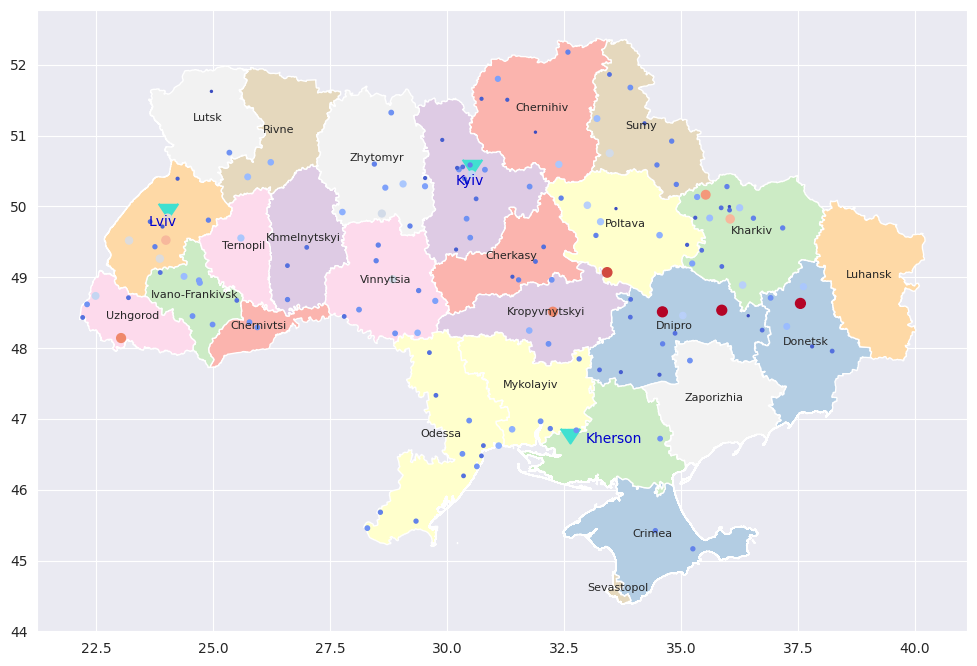

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

plot_map(df_regions, ax)

df_destinations.plot(ax=ax, marker='o', markersize=2 * df_destinations['capacity'], column='capacity', cmap='coolwarm')

## Plot new random destination points

In [10]:
capacities = list(df_destinations['capacity'].values)

In [11]:
df_new = pd.DataFrame(columns=df_cities.columns)
new_cap = []
i = 0
while i < 100:
    region = choice(df_destinations["region"])
    possible_cities = df_cities[df_cities["region"] == region]
    if len(possible_cities.index) >=1:
        city = choice(possible_cities.index)
        df_new.loc[len(df_new.index)] = df_cities.iloc[city]
        capacity = choice(capacities)
        new_cap.append(capacity)
        i += 1

In [12]:
df_new['capacity'] = new_cap
points = [Point(d['longitude'], d['latitude']) for d in map(json.loads, df_new['location'].to_numpy())]

df_new = GeoDataFrame(df_new, geometry=points, crs=df_regions.crs)
df_new.head()

,name,location,population,latitude,longitude,region,geometry,capacity
0,Oposhnya,"{""__type"":""GeoPoint"",""latitude"":49.95652,""long...",6003,49.95652,34.61226,Poltavska,POINT (34.61226 49.95652),2
1,Olevs’k,"{""__type"":""GeoPoint"",""latitude"":51.22482,""long...",0,51.22482,27.65228,Zhytomyrska,POINT (27.65228 51.22482),5
2,Serebriya,"{""__type"":""GeoPoint"",""latitude"":48.45593,""long...",2906,48.45593,27.71923,Vinnytska,POINT (27.71923 48.45593),5
3,Piatykhatky,"{""__type"":""GeoPoint"",""latitude"":48.41333,""long...",20459,48.41333,33.71056,Dnipropetrovska,POINT (33.71056 48.41333),5
4,Ochakiv,"{""__type"":""GeoPoint"",""latitude"":46.61283,""long...",16300,46.61283,31.54982,Mykolaivska,POINT (31.54982 46.61283),5


In [13]:
df_new

,name,location,population,latitude,longitude,region,geometry,capacity
0,Oposhnya,"{""__type"":""GeoPoint"",""latitude"":49.95652,""long...",6003,49.95652,34.61226,Poltavska,POINT (34.61226 49.95652),2
1,Olevs’k,"{""__type"":""GeoPoint"",""latitude"":51.22482,""long...",0,51.22482,27.65228,Zhytomyrska,POINT (27.65228 51.22482),5
2,Serebriya,"{""__type"":""GeoPoint"",""latitude"":48.45593,""long...",2906,48.45593,27.71923,Vinnytska,POINT (27.71923 48.45593),5
3,Piatykhatky,"{""__type"":""GeoPoint"",""latitude"":48.41333,""long...",20459,48.41333,33.71056,Dnipropetrovska,POINT (33.71056 48.41333),5
4,Ochakiv,"{""__type"":""GeoPoint"",""latitude"":46.61283,""long...",16300,46.61283,31.54982,Mykolaivska,POINT (31.54982 46.61283),5
...,...,...,...,...,...,...,...,...
95,Okny,"{""__type"":""GeoPoint"",""latitude"":47.54044,""long...",5461,47.54044,29.46001,Odeska,POINT (29.46001 47.54044),7
96,Ol'shanskoye,"{""__type"":""GeoPoint"",""latitude"":47.18411,""long...",4500,47.18411,31.79375,Mykolaivska,POINT (31.79375 47.18411),9
97,Mezenivka,"{""__type"":""GeoPoint"",""latitude"":50.63486,""long...",1273,50.63486,35.3134,Sumska,POINT (35.31340 50.63486),5
98,Orzhytsya,"{""__type"":""GeoPoint"",""latitude"":49.7901,""longi...",3898,49.7901,32.69941,Poltavska,POINT (32.69941 49.79010),5


<AxesSubplot: >

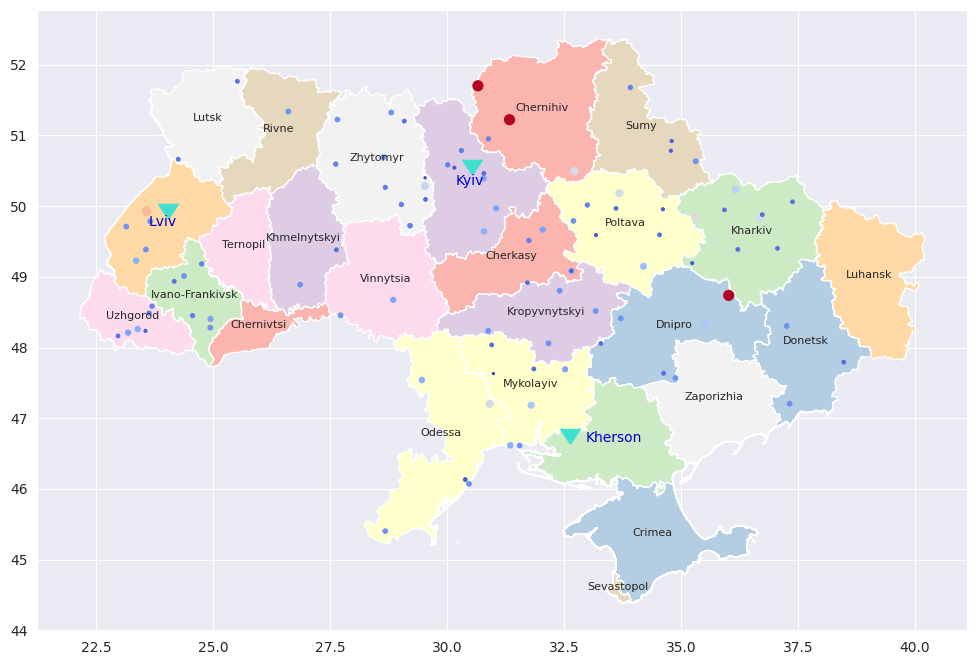

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 12))

plot_map(df_regions, ax1)

df_new.plot(ax=ax1, marker='o', markersize=2*df_new['capacity'], column='capacity', cmap='coolwarm')

In [15]:
best_new_warehouses = None
best_clustering = None
best_total_distance = float('inf')
prev_best_total_distance = float('inf')

for num_new_warehouses in range(1, 2):
    for _ in range(10):
        new_warehouses = random.sample(tuple(possible_warehouses), num_new_warehouses)
        all_warehouses = warehouses.union(new_warehouses)
        all_warehouses_df = df_cities.loc[df_cities.name.isin(all_warehouses)][['name', 'latitude', 'longitude']]

        def get_closest_warehouse(target):
            distances = all_warehouses_df.apply(lambda w: distance.geodesic(target[1:], w[1:]).km, axis=1)
            warehouse_idx = distances.argmin()
            return pd.Series({'name': target[:1].values[0], 'closest_warehouse': all_warehouses_df.iloc[warehouse_idx]['name'], 'distance': distances.min()})

        targets = df_new[['name', 'latitude', 'longitude']]
        clustering = targets.apply(get_closest_warehouse, axis=1)
        total_distance = clustering.distance.sum()

        if total_distance < best_total_distance:
            best_new_warehouses = new_warehouses
            best_clustering = clustering
            best_total_distance = total_distance

    if best_total_distance >= prev_best_total_distance:
        break
    prev_best_total_distance = best_total_distance

print(best_new_warehouses)

['Rivne']


In [16]:
best_new_warehouses = None
best_clustering = None
best_total_distance = float('inf')
prev_best_total_distance = float('inf')

for num_new_warehouses in range(1, 6):
    for _ in range(10):
        new_warehouses = random.sample(tuple(possible_warehouses), num_new_warehouses)
        all_warehouses = warehouses.union(new_warehouses)
        all_warehouses_df = df_cities.loc[df_cities.name.isin(all_warehouses)][['name', 'latitude', 'longitude']]

        def get_closest_warehouse(target):
            distances = all_warehouses_df.apply(lambda w: distance.geodesic(target[1:], w[1:]).km, axis=1)
            warehouse_idx = distances.argmin()
            return pd.Series({'name': target[:1].values[0], 'closest_warehouse': all_warehouses_df.iloc[warehouse_idx]['name'], 'distance': distances.min()})

        targets = df_new[['name', 'latitude', 'longitude']]
        clustering = targets.apply(get_closest_warehouse, axis=1)
        total_distance = clustering.distance.sum()

        if total_distance < best_total_distance:
            best_new_warehouses = new_warehouses
            best_clustering = clustering
            best_total_distance = total_distance

    if best_total_distance >= prev_best_total_distance:
        break
    prev_best_total_distance = best_total_distance

print(best_new_warehouses)

['Poltava', 'Lutsk', 'Zhytomyr', 'Rivne', 'Kharkiv']
